# Exercise Sheet 3: Multi Layer Perceptrons (MLPs)

In [269]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from sklearn.datasets import make_moons

from tqdm import tqdm
import numpy as np
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (6.0, 4.0)

import pprint
pp = pprint.PrettyPrinter(indent=4)


# Set random seed for reproducibility
SEED = 42
RESULTS_PATH = "./results"

torch.manual_seed(SEED)
np.random.seed(SEED)

### Task 1: Backpropagation and Simple Training


For the linear layer we need two derivates towards the trainable parameters
\begin{align}
\frac{\partial f_j}{\partial b_j}&=1\\
\frac{\partial f_j}{\partial w_{ji}}&=x_i
\end{align}
and one towards the input
\begin{equation}
\frac{\partial f_j}{\partial x_i}=w_{ji}
\end{equation}


For the ReLU unit $g=\max\left(0,f\right)$ we have the following gradient:
\begin{equation}
\frac{\partial g}{\partial f}=
\begin{cases}
    1 & \text{if}~f>0\\
    0 & \text{if}~f<0
\end{cases}
\end{equation}
Keep in mind that the derivative at $f=0$ does not exists.

In [270]:
def standard_normalization(x):
    """Default normalization function. Normalizes the input x."""
    return (x - x.mean()) / x.std()

def moving_average(x, w):
    """Compute the moving average of x with window size w."""
    return np.convolve(x, np.ones(w), 'valid') / w

def normaldist_init(input_size, output_size):
    """Get some random numbers based on Normal Distribution to initialize weights."""
    # Normal distribution initialization
    return torch.randn(1, output_size, input_size)/(input_size + 1)
    
def xavier_init(input_size, output_size):
    """ Get some random number to initialize weights."""
    # Xavier initialization
    return torch.randn(1, output_size, input_size)/(input_size + 1) * np.sqrt(2.0 / (input_size + output_size))

In [271]:
# 1. Complete forward, backward pass, and update for Linear and ReLU
class Linear:
    def __init__(self, in_channels, out_channels):
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # initialize weights and biases
        # https://pytorch.org/docs/stable/nn.init.html
        self.weight = normaldist_init(in_channels, out_channels)
        self.bias = torch.zeros(1, out_channels)
        
        self.last_input = None
        self.grad_weight = None
        self.grad_bias = None
        
    def forward(self, x, remember=False):
        if remember:
            self.last_input = x

        # https://pytorch.org/docs/stable/generated/torch.einsum.html
        # https://stackoverflow.com/questions/55894693/understanding-pytorch-einsum    
        return torch.einsum("bji,bi->bj", self.weight, x) + self.bias
    
    def backward(self, gradient):
        self.grad_weight = torch.mean(torch.einsum("bj,bi->bji", gradient, self.last_input), dim=0)
        self.grad_bias = torch.mean(gradient, dim=0) # gradient * 1

        # return the grad to next layer
        # upper grad mm the grad towards the input
        return torch.einsum("bj,bji->bi", gradient, self.weight)
    
    def update(self, learning_rate):
        # gradient descent
        self.weight = self.weight - learning_rate*self.grad_weight
        self.bias = self.bias - learning_rate*self.grad_bias
        
        
class ReLU:
    def __init__(self):
        self.last_input = None
    
    def forward(self, x, remember=False):
        if remember:
            self.last_input = x
        
        # ReLU activation
        x = torch.max(x, torch.zeros_like(x))
        return x
    
    def backward(self, gradient):
        # ReLU gradient - check where input is larger than zero return 1, else 0
        gradient = torch.where(self.last_input > 0, gradient, 0.0)
        return gradient
    
    def update(self, learning_rate):
        # we don't have any parameters in ReLU layer here
        # other ReLU activations can have parameters that might need to be learned
        pass

class LeakyReLU:
    def __init__(self):
        self.last_input = None


    def forward(self, x, remember=False):
        if remember:
            self.last_input = x

        # Leaky ReLU activation
        x = torch.max(x, 0.01*x)
        return x
    
    def backward(self, gradient):
        # Leaky ReLU gradient - check where input is larger than zero return 1, else 0
        gradient = torch.where(self.last_input > 0, gradient, 0.01*gradient)
        return gradient

    def update(self, learning_rate):
        # we don't have any parameters in ReLU layer here
        # other ReLU activations can have parameters that might need to be learned
        pass
    

In [272]:
class Softmax:
    """ Numerically stable Softmax implementation since we take the max() 
        of the input per samples not per batch. 
        We constrain it into a range of 0 to 1.
    """
    def __init__(self, dim=-1):
        self.last_output = None
        self.dim = dim
        
    def forward(self, x, remember=False):
        x = torch.exp(x - torch.amax(x, dim=-1, keepdims=True)) # numerical stable version -> normalize by max(x) over the last dimension
        x = x/(torch.sum(x, dim=self.dim, keepdim=True)+1e-12)
        if remember:
            self.last_output = x
        return x
    
    def backward(self, gradient):
        jacobian = -self.last_output[:,:,None]*self.last_output[:,None,:] #BxLxL
        #correct diagonal entries
        jacobian += torch.eye(self.last_output.size(-1)).unsqueeze(0)*self.last_output.unsqueeze(-1).repeat(1,1,self.last_output.size(-1))
        # you can use any character, but make sure they are consistent
        return torch.einsum("bj,bji->bi", gradient, jacobian)
    
    def update(self, learning_rate):
        #we don't have any parameters here
        pass

In [273]:
class CrossEntropyLoss:
    def __init__(self, dim=-1):
        self.last_input = None
        self.last_ground_truth = None
        self.dim = dim
    
    def forward(self, p, y):
        #convert y to one hot
        one_hot = torch.eye(p.size(-1))[y]
        self.last_input = p
        self.last_ground_truth = one_hot
        
        losses = -torch.sum(one_hot*torch.log(p), dim=-1)
        total_loss = torch.mean(losses)
        
        return total_loss
    
    def backward(self):
        return torch.where(self.last_ground_truth==1,-1.0/self.last_input, 0.0)

In [274]:
class MLP:
    def __init__(self, in_channels=2, hidden_channels=[], out_channels=2):
        self.in_channels = in_channels
        
        self.layers = []
        if len(hidden_channels)==0:
            self.layers.append(Linear(in_channels, out_channels))
        else:
            self.layers.append(Linear(in_channels, hidden_channels[0]))
            self.layers.append(LeakyReLU())
            for i in range(len(hidden_channels)-1):
                self.layers.append(Linear(hidden_channels[i], hidden_channels[i+1]))
                self.layers.append(LeakyReLU())
            self.layers.append(Linear(hidden_channels[-1], out_channels))
        self.layers.append(Softmax(dim=-1))
        
        self.criterion = CrossEntropyLoss(dim=-1)
        
    def forward(self, x, remember=False):
        for layer in self.layers:
            x = layer.forward(x, remember=remember)
        return x
    
    def backward(self): #calculate gradients
        grad = self.criterion.backward()
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def update(self, learning_rate): #update each layer via gradient descent
        for layer in self.layers:
            layer.update(learning_rate)
    
    def training_step(self, x, y, learning_rate):
        probabilities = self.forward(x, remember=True) #store inputs for backward pass!
        loss = self.criterion.forward(probabilities, y)
        self.backward() #calculate gradients
        self.update(learning_rate) #update using gradient descent
        
        return loss

In [275]:
def train_network(mlp, Ntrain, Ntest, Xtrain, ytrain, Xtest, ytest, num_epochs=10, batch_size=32, learning_rate=5e-3):
    num_batches_train = int(np.ceil(Ntrain/batch_size))
    num_batches_test = int(np.ceil(Ntest/batch_size))

    #train network
    losses_train = []
    losses_test = []
    
    for epoch in range(num_epochs):
        #reshuffle training data
        ind = np.random.permutation(len(Xtrain))
        Xtrain = Xtrain[ind]
        ytrain = ytrain[ind]

        #training pass
        for it in tqdm(range(num_batches_train)):
            start = it*batch_size
            end = min((it+1)*batch_size, len(Xtrain))
            X = torch.FloatTensor(Xtrain[start:end])
            y = torch.LongTensor(ytrain[start:end])

            # compute loss and update weights
            loss = mlp.training_step(X, y, learning_rate)
            losses_train.append(loss.item())

            # update weights
            mlp.update(learning_rate)

            if it%10==0:
                print(f"Epoch {epoch+1}/{num_epochs}, Iteration {it+1}/{num_batches_train}, Train Loss: {loss.item()}")

        #testing pass
        for it in tqdm(range(num_batches_test)):
            start = it*batch_size
            end = min((it+1)*batch_size, len(Xtest))
            X = torch.FloatTensor(Xtest[start:end])
            y = torch.LongTensor(ytest[start:end])

            # compute loss
            probabilities = mlp.forward(X)
            loss = mlp.criterion.forward(probabilities, y)
            losses_test.append(loss.item())

            if it%10==0:
                print(f"Epoch {epoch+1}/{num_epochs}, Iteration {it+1}/{num_batches_test}, Test Loss: {loss.item()}")


    return losses_train, losses_test


In [276]:
#create datasets
Ntrain = 8000
Ntest = 2000
Xtrain, ytrain = make_moons(n_samples=Ntrain, noise=0.1, random_state=42)
Xtest, ytest = make_moons(n_samples=Ntest, noise=0.1, random_state=42)

print(Xtrain.shape, ytrain.shape)

(8000, 2) (8000,)


In [277]:
# 2. Implement missing parts in the training routine

losses_train = []
losses_test = []

# rescale data (normalise) to [-1,1]
amin = np.amin(Xtrain, axis=0, keepdims=True)
amax = np.amax(Xtrain, axis=0, keepdims=True)

Xtrain = ((Xtrain-amin)/(amax-amin)-0.5)/0.5
Xtest = ((Xtest-amin)/(amax-amin)-0.5)/0.5

batch_size = 32
num_epochs = 10
learning_rate = 5e-2

# create MLP
hidden_channels = [30,30]
mlp = MLP(2, hidden_channels, 2)

# train network
losses_train, losses_test = train_network(mlp, Ntrain, Ntest, Xtrain, ytrain, Xtest, ytest, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate)


100%|██████████| 250/250 [00:00<00:00, 2808.89it/s]


Epoch 1/10, Iteration 1/250, Train Loss: 0.6931536197662354
Epoch 1/10, Iteration 11/250, Train Loss: 0.6922574043273926
Epoch 1/10, Iteration 21/250, Train Loss: 0.693392813205719
Epoch 1/10, Iteration 31/250, Train Loss: 0.6904457211494446
Epoch 1/10, Iteration 41/250, Train Loss: 0.6870915293693542
Epoch 1/10, Iteration 51/250, Train Loss: 0.6927298903465271
Epoch 1/10, Iteration 61/250, Train Loss: 0.690376877784729
Epoch 1/10, Iteration 71/250, Train Loss: 0.6933885812759399
Epoch 1/10, Iteration 81/250, Train Loss: 0.6970893144607544
Epoch 1/10, Iteration 91/250, Train Loss: 0.6927967071533203
Epoch 1/10, Iteration 101/250, Train Loss: 0.6961188912391663
Epoch 1/10, Iteration 111/250, Train Loss: 0.6914398670196533
Epoch 1/10, Iteration 121/250, Train Loss: 0.6935683488845825
Epoch 1/10, Iteration 131/250, Train Loss: 0.6937865018844604
Epoch 1/10, Iteration 141/250, Train Loss: 0.6937504410743713
Epoch 1/10, Iteration 151/250, Train Loss: 0.6917412877082825
Epoch 1/10, Iteration

100%|██████████| 63/63 [00:00<00:00, 8186.16it/s]


Epoch 1/10, Iteration 1/63, Test Loss: 0.6969772577285767
Epoch 1/10, Iteration 11/63, Test Loss: 0.70634925365448
Epoch 1/10, Iteration 21/63, Test Loss: 0.6871402263641357
Epoch 1/10, Iteration 31/63, Test Loss: 0.7064836025238037
Epoch 1/10, Iteration 41/63, Test Loss: 0.6805237531661987
Epoch 1/10, Iteration 51/63, Test Loss: 0.6868945956230164
Epoch 1/10, Iteration 61/63, Test Loss: 0.6967055797576904


100%|██████████| 250/250 [00:00<00:00, 2781.09it/s]


Epoch 2/10, Iteration 1/250, Train Loss: 0.6803392171859741
Epoch 2/10, Iteration 11/250, Train Loss: 0.6806121468544006
Epoch 2/10, Iteration 21/250, Train Loss: 0.6901684999465942
Epoch 2/10, Iteration 31/250, Train Loss: 0.6876459121704102
Epoch 2/10, Iteration 41/250, Train Loss: 0.6848523616790771
Epoch 2/10, Iteration 51/250, Train Loss: 0.6825265884399414
Epoch 2/10, Iteration 61/250, Train Loss: 0.6925652623176575
Epoch 2/10, Iteration 71/250, Train Loss: 0.687301516532898
Epoch 2/10, Iteration 81/250, Train Loss: 0.6937752366065979
Epoch 2/10, Iteration 91/250, Train Loss: 0.6873027086257935
Epoch 2/10, Iteration 101/250, Train Loss: 0.6854843497276306
Epoch 2/10, Iteration 111/250, Train Loss: 0.6795427203178406
Epoch 2/10, Iteration 121/250, Train Loss: 0.682691752910614
Epoch 2/10, Iteration 131/250, Train Loss: 0.670952320098877
Epoch 2/10, Iteration 141/250, Train Loss: 0.6697602868080139
Epoch 2/10, Iteration 151/250, Train Loss: 0.6580376625061035
Epoch 2/10, Iteration 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/10, Iteration 1/63, Test Loss: 0.36331307888031006
Epoch 2/10, Iteration 11/63, Test Loss: 0.18480603396892548
Epoch 2/10, Iteration 21/63, Test Loss: 0.43641236424446106
Epoch 2/10, Iteration 31/63, Test Loss: 0.22917893528938293


100%|██████████| 63/63 [00:00<00:00, 8217.73it/s]


Epoch 2/10, Iteration 41/63, Test Loss: 0.31495264172554016
Epoch 2/10, Iteration 51/63, Test Loss: 0.23156052827835083
Epoch 2/10, Iteration 61/63, Test Loss: 0.2650517225265503


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3/10, Iteration 1/250, Train Loss: 0.25154584646224976


100%|██████████| 250/250 [00:00<00:00, 2879.09it/s]


Epoch 3/10, Iteration 11/250, Train Loss: 0.22228120267391205
Epoch 3/10, Iteration 21/250, Train Loss: 0.29613661766052246
Epoch 3/10, Iteration 31/250, Train Loss: 0.207230806350708
Epoch 3/10, Iteration 41/250, Train Loss: 0.33918213844299316
Epoch 3/10, Iteration 51/250, Train Loss: 0.28202691674232483
Epoch 3/10, Iteration 61/250, Train Loss: 0.39148274064064026
Epoch 3/10, Iteration 71/250, Train Loss: 0.22106105089187622
Epoch 3/10, Iteration 81/250, Train Loss: 0.11526455730199814
Epoch 3/10, Iteration 91/250, Train Loss: 0.3561704754829407
Epoch 3/10, Iteration 101/250, Train Loss: 0.1733240932226181
Epoch 3/10, Iteration 111/250, Train Loss: 0.23955675959587097
Epoch 3/10, Iteration 121/250, Train Loss: 0.37826138734817505
Epoch 3/10, Iteration 131/250, Train Loss: 0.12486251443624496
Epoch 3/10, Iteration 141/250, Train Loss: 0.1506483256816864
Epoch 3/10, Iteration 151/250, Train Loss: 0.41998112201690674
Epoch 3/10, Iteration 161/250, Train Loss: 0.40268203616142273
Epoch 

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/10, Iteration 1/63, Test Loss: 0.3363628387451172
Epoch 3/10, Iteration 11/63, Test Loss: 0.14636582136154175
Epoch 3/10, Iteration 21/63, Test Loss: 0.4069315791130066
Epoch 3/10, Iteration 31/63, Test Loss: 0.1955440640449524


100%|██████████| 63/63 [00:00<00:00, 8203.19it/s]


Epoch 3/10, Iteration 41/63, Test Loss: 0.26751601696014404
Epoch 3/10, Iteration 51/63, Test Loss: 0.19358211755752563
Epoch 3/10, Iteration 61/63, Test Loss: 0.2404380440711975


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/10, Iteration 1/250, Train Loss: 0.09221962094306946


100%|██████████| 250/250 [00:00<00:00, 2866.22it/s]


Epoch 4/10, Iteration 11/250, Train Loss: 0.29818445444107056
Epoch 4/10, Iteration 21/250, Train Loss: 0.22690874338150024
Epoch 4/10, Iteration 31/250, Train Loss: 0.2868475019931793
Epoch 4/10, Iteration 41/250, Train Loss: 0.27735790610313416
Epoch 4/10, Iteration 51/250, Train Loss: 0.2134494036436081
Epoch 4/10, Iteration 61/250, Train Loss: 0.24731582403182983
Epoch 4/10, Iteration 71/250, Train Loss: 0.3123963177204132
Epoch 4/10, Iteration 81/250, Train Loss: 0.2621293365955353
Epoch 4/10, Iteration 91/250, Train Loss: 0.23296479880809784
Epoch 4/10, Iteration 101/250, Train Loss: 0.20101094245910645
Epoch 4/10, Iteration 111/250, Train Loss: 0.09833410382270813
Epoch 4/10, Iteration 121/250, Train Loss: 0.2596404552459717
Epoch 4/10, Iteration 131/250, Train Loss: 0.32226666808128357
Epoch 4/10, Iteration 141/250, Train Loss: 0.2149743139743805
Epoch 4/10, Iteration 151/250, Train Loss: 0.1660463511943817
Epoch 4/10, Iteration 161/250, Train Loss: 0.1877487450838089
Epoch 4/1

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/10, Iteration 1/63, Test Loss: 0.38447925448417664
Epoch 4/10, Iteration 11/63, Test Loss: 0.1690143644809723
Epoch 4/10, Iteration 21/63, Test Loss: 0.39719632267951965
Epoch 4/10, Iteration 31/63, Test Loss: 0.18631431460380554
Epoch 4/10, Iteration 41/63, Test Loss: 0.2720964252948761
Epoch 4/10, Iteration 51/63, Test Loss: 0.21602779626846313


100%|██████████| 63/63 [00:00<00:00, 8188.45it/s]


Epoch 4/10, Iteration 61/63, Test Loss: 0.27643007040023804


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5/10, Iteration 1/250, Train Loss: 0.30829915404319763
Epoch 5/10, Iteration 11/250, Train Loss: 0.244589701294899
Epoch 5/10, Iteration 21/250, Train Loss: 0.2991103231906891


100%|██████████| 250/250 [00:00<00:00, 2795.79it/s]


Epoch 5/10, Iteration 31/250, Train Loss: 0.1366136521100998
Epoch 5/10, Iteration 41/250, Train Loss: 0.26149263978004456
Epoch 5/10, Iteration 51/250, Train Loss: 0.11813528835773468
Epoch 5/10, Iteration 61/250, Train Loss: 0.15705053508281708
Epoch 5/10, Iteration 71/250, Train Loss: 0.16726504266262054
Epoch 5/10, Iteration 81/250, Train Loss: 0.08587702363729477
Epoch 5/10, Iteration 91/250, Train Loss: 0.2567194998264313
Epoch 5/10, Iteration 101/250, Train Loss: 0.13271471858024597
Epoch 5/10, Iteration 111/250, Train Loss: 0.22549544274806976
Epoch 5/10, Iteration 121/250, Train Loss: 0.2822436988353729
Epoch 5/10, Iteration 131/250, Train Loss: 0.13936775922775269
Epoch 5/10, Iteration 141/250, Train Loss: 0.09727689623832703
Epoch 5/10, Iteration 151/250, Train Loss: 0.23089580237865448
Epoch 5/10, Iteration 161/250, Train Loss: 0.2512803375720978
Epoch 5/10, Iteration 171/250, Train Loss: 0.31526055932044983
Epoch 5/10, Iteration 181/250, Train Loss: 0.2784010171890259
Epoc

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/10, Iteration 1/63, Test Loss: 0.3014645278453827
Epoch 5/10, Iteration 11/63, Test Loss: 0.12935355305671692
Epoch 5/10, Iteration 21/63, Test Loss: 0.3407558500766754


100%|██████████| 63/63 [00:00<00:00, 7319.50it/s]

Epoch 5/10, Iteration 31/63, Test Loss: 0.17188753187656403
Epoch 5/10, Iteration 41/63, Test Loss: 0.22158756852149963
Epoch 5/10, Iteration 51/63, Test Loss: 0.17225497961044312
Epoch 5/10, Iteration 61/63, Test Loss: 0.21025992929935455



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6/10, Iteration 1/250, Train Loss: 0.2980208098888397
Epoch 6/10, Iteration 11/250, Train Loss: 0.20044563710689545
Epoch 6/10, Iteration 21/250, Train Loss: 0.19987045228481293
Epoch 6/10, Iteration 31/250, Train Loss: 0.29881176352500916
Epoch 6/10, Iteration 41/250, Train Loss: 0.3241143524646759
Epoch 6/10, Iteration 51/250, Train Loss: 0.1656120866537094
Epoch 6/10, Iteration 61/250, Train Loss: 0.3365163207054138
Epoch 6/10, Iteration 71/250, Train Loss: 0.34046366810798645
Epoch 6/10, Iteration 81/250, Train Loss: 0.29204121232032776
Epoch 6/10, Iteration 91/250, Train Loss: 0.22341111302375793
Epoch 6/10, Iteration 101/250, Train Loss: 0.09982743114233017
Epoch 6/10, Iteration 111/250, Train Loss: 0.37092259526252747
Epoch 6/10, Iteration 121/250, Train Loss: 0.22802773118019104
Epoch 6/10, Iteration 131/250, Train Loss: 0.08580461889505386
Epoch 6/10, Iteration 141/250, Train Loss: 0.20722061395645142
Epoch 6/10, Iteration 151/250, Train Loss: 0.18144142627716064
Epoch 6

100%|██████████| 250/250 [00:00<00:00, 2569.55it/s]


Epoch 6/10, Iteration 241/250, Train Loss: 0.23316842317581177


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/10, Iteration 1/63, Test Loss: 0.19108682870864868
Epoch 6/10, Iteration 11/63, Test Loss: 0.07920433580875397
Epoch 6/10, Iteration 21/63, Test Loss: 0.22492772340774536
Epoch 6/10, Iteration 31/63, Test Loss: 0.1301451176404953
Epoch 6/10, Iteration 41/63, Test Loss: 0.1393357217311859


100%|██████████| 63/63 [00:00<00:00, 6748.08it/s]


Epoch 6/10, Iteration 51/63, Test Loss: 0.1202956959605217
Epoch 6/10, Iteration 61/63, Test Loss: 0.14145421981811523


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7/10, Iteration 1/250, Train Loss: 0.13158491253852844
Epoch 7/10, Iteration 11/250, Train Loss: 0.10117904841899872
Epoch 7/10, Iteration 21/250, Train Loss: 0.12447325885295868
Epoch 7/10, Iteration 31/250, Train Loss: 0.11583980172872543
Epoch 7/10, Iteration 41/250, Train Loss: 0.12461201101541519
Epoch 7/10, Iteration 51/250, Train Loss: 0.08780763298273087
Epoch 7/10, Iteration 61/250, Train Loss: 0.08276961743831635
Epoch 7/10, Iteration 71/250, Train Loss: 0.07067078351974487
Epoch 7/10, Iteration 81/250, Train Loss: 0.15998177230358124
Epoch 7/10, Iteration 91/250, Train Loss: 0.1734951287508011
Epoch 7/10, Iteration 101/250, Train Loss: 0.06789156049489975
Epoch 7/10, Iteration 111/250, Train Loss: 0.20468908548355103
Epoch 7/10, Iteration 121/250, Train Loss: 0.13964150846004486
Epoch 7/10, Iteration 131/250, Train Loss: 0.08946561813354492
Epoch 7/10, Iteration 141/250, Train Loss: 0.054833345115184784
Epoch 7/10, Iteration 151/250, Train Loss: 0.10563701391220093
Epo

100%|██████████| 250/250 [00:00<00:00, 2743.60it/s]


Epoch 7/10, Iteration 241/250, Train Loss: 0.09234671294689178


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/10, Iteration 1/63, Test Loss: 0.08463630825281143
Epoch 7/10, Iteration 11/63, Test Loss: 0.03468652814626694
Epoch 7/10, Iteration 21/63, Test Loss: 0.08094049245119095
Epoch 7/10, Iteration 31/63, Test Loss: 0.05634957179427147
Epoch 7/10, Iteration 41/63, Test Loss: 0.05421196669340134


100%|██████████| 63/63 [00:00<00:00, 7510.69it/s]


Epoch 7/10, Iteration 51/63, Test Loss: 0.06679217517375946
Epoch 7/10, Iteration 61/63, Test Loss: 0.07549150288105011


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8/10, Iteration 1/250, Train Loss: 0.08779670298099518
Epoch 8/10, Iteration 11/250, Train Loss: 0.0387447252869606
Epoch 8/10, Iteration 21/250, Train Loss: 0.020358625799417496
Epoch 8/10, Iteration 31/250, Train Loss: 0.08441443741321564
Epoch 8/10, Iteration 41/250, Train Loss: 0.02420790307223797
Epoch 8/10, Iteration 51/250, Train Loss: 0.04217467084527016
Epoch 8/10, Iteration 61/250, Train Loss: 0.03137403726577759
Epoch 8/10, Iteration 71/250, Train Loss: 0.039461299777030945
Epoch 8/10, Iteration 81/250, Train Loss: 0.060777533799409866
Epoch 8/10, Iteration 91/250, Train Loss: 0.06081318482756615
Epoch 8/10, Iteration 101/250, Train Loss: 0.06037209555506706
Epoch 8/10, Iteration 111/250, Train Loss: 0.036752402782440186
Epoch 8/10, Iteration 121/250, Train Loss: 0.0393044650554657
Epoch 8/10, Iteration 131/250, Train Loss: 0.0404997281730175
Epoch 8/10, Iteration 141/250, Train Loss: 0.031848397105932236
Epoch 8/10, Iteration 151/250, Train Loss: 0.03465976566076279
E

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/10, Iteration 1/63, Test Loss: 0.046968936920166016
Epoch 8/10, Iteration 11/63, Test Loss: 0.013553960248827934
Epoch 8/10, Iteration 21/63, Test Loss: 0.038198549300432205
Epoch 8/10, Iteration 31/63, Test Loss: 0.027969174087047577
Epoch 8/10, Iteration 41/63, Test Loss: 0.019945451989769936
Epoch 8/10, Iteration 51/63, Test Loss: 0.03206881508231163


100%|██████████| 63/63 [00:00<00:00, 6302.56it/s]


Epoch 8/10, Iteration 61/63, Test Loss: 0.03336717188358307


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9/10, Iteration 1/250, Train Loss: 0.017532363533973694
Epoch 9/10, Iteration 11/250, Train Loss: 0.042844630777835846
Epoch 9/10, Iteration 21/250, Train Loss: 0.01663181371986866
Epoch 9/10, Iteration 31/250, Train Loss: 0.030724409967660904
Epoch 9/10, Iteration 41/250, Train Loss: 0.025487404316663742
Epoch 9/10, Iteration 51/250, Train Loss: 0.10710650682449341
Epoch 9/10, Iteration 61/250, Train Loss: 0.09059562534093857
Epoch 9/10, Iteration 71/250, Train Loss: 0.016325438395142555
Epoch 9/10, Iteration 81/250, Train Loss: 0.007734930142760277
Epoch 9/10, Iteration 91/250, Train Loss: 0.016456933692097664
Epoch 9/10, Iteration 101/250, Train Loss: 0.05025655776262283
Epoch 9/10, Iteration 111/250, Train Loss: 0.07354705035686493
Epoch 9/10, Iteration 121/250, Train Loss: 0.0382237546145916
Epoch 9/10, Iteration 131/250, Train Loss: 0.03199375420808792
Epoch 9/10, Iteration 141/250, Train Loss: 0.0171235091984272
Epoch 9/10, Iteration 151/250, Train Loss: 0.0173893552273511

100%|██████████| 63/63 [00:00<00:00, 6221.68it/s]


Epoch 9/10, Iteration 1/63, Test Loss: 0.020138386636972427
Epoch 9/10, Iteration 11/63, Test Loss: 0.009356934577226639
Epoch 9/10, Iteration 21/63, Test Loss: 0.021962132304906845
Epoch 9/10, Iteration 31/63, Test Loss: 0.0197189562022686
Epoch 9/10, Iteration 41/63, Test Loss: 0.008356645703315735
Epoch 9/10, Iteration 51/63, Test Loss: 0.020149484276771545
Epoch 9/10, Iteration 61/63, Test Loss: 0.019468385726213455


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10/10, Iteration 1/250, Train Loss: 0.03315866366028786
Epoch 10/10, Iteration 11/250, Train Loss: 0.022253097966313362
Epoch 10/10, Iteration 21/250, Train Loss: 0.013422484509646893
Epoch 10/10, Iteration 31/250, Train Loss: 0.013845530338585377
Epoch 10/10, Iteration 41/250, Train Loss: 0.018505515530705452
Epoch 10/10, Iteration 51/250, Train Loss: 0.004377315286546946
Epoch 10/10, Iteration 61/250, Train Loss: 0.013597407378256321
Epoch 10/10, Iteration 71/250, Train Loss: 0.010611903853714466
Epoch 10/10, Iteration 81/250, Train Loss: 0.02573251724243164
Epoch 10/10, Iteration 91/250, Train Loss: 0.01668694242835045
Epoch 10/10, Iteration 101/250, Train Loss: 0.014396518468856812
Epoch 10/10, Iteration 111/250, Train Loss: 0.009837938472628593
Epoch 10/10, Iteration 121/250, Train Loss: 0.04053540900349617
Epoch 10/10, Iteration 131/250, Train Loss: 0.011299499310553074
Epoch 10/10, Iteration 141/250, Train Loss: 0.017248449847102165
Epoch 10/10, Iteration 151/250, Train Lo

100%|██████████| 250/250 [00:00<00:00, 2642.25it/s]


Epoch 10/10, Iteration 241/250, Train Loss: 0.011885895393788815


100%|██████████| 63/63 [00:00<00:00, 7947.58it/s]

Epoch 10/10, Iteration 1/63, Test Loss: 0.020242933183908463
Epoch 10/10, Iteration 11/63, Test Loss: 0.005055363290011883
Epoch 10/10, Iteration 21/63, Test Loss: 0.01675483025610447
Epoch 10/10, Iteration 31/63, Test Loss: 0.013794501312077045
Epoch 10/10, Iteration 41/63, Test Loss: 0.004893752746284008
Epoch 10/10, Iteration 51/63, Test Loss: 0.013044946826994419
Epoch 10/10, Iteration 61/63, Test Loss: 0.01373495813459158


In [278]:
def plot_loss_curves(losses_train, losses_test, path=RESULTS_PATH, file_name="losses"):
    # Plot two separate curves for training and test loss
    plt.figure(figsize=(10, 6))

    plt.plot(losses_train, label="Train Loss")
    plt.plot(losses_test, label="Test Loss")

    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Loss Curves")

    plt.legend()
    plt.grid(True)
    plt.savefig(f"{path}/{file_name}.png", dpi=300)
    plt.show()

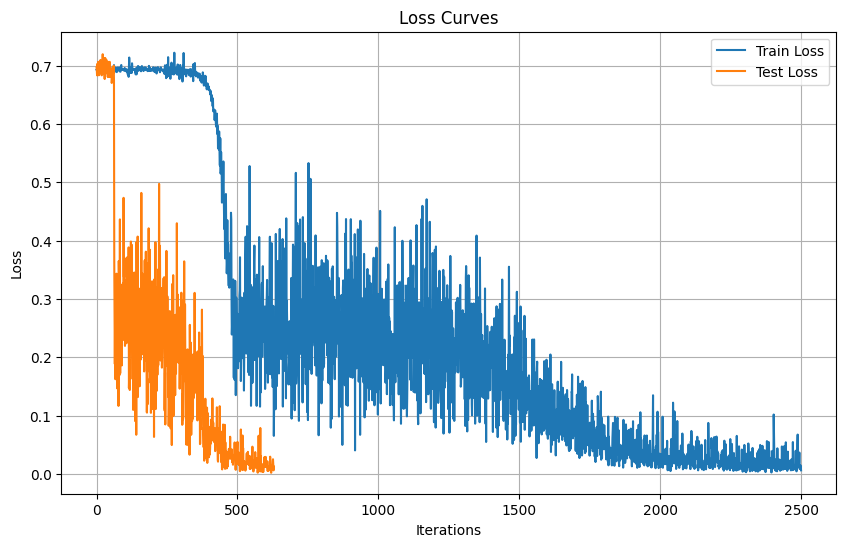

In [279]:
# 3. Plot loss curves on training and test set
plot_loss_curves(losses_train, losses_test, file_name="mlp_loss_curves_small_2")

In [280]:
# 4. Increase the number of hidden units and observe the effect on the loss curves
# create MLP
batch_size = 32
num_epochs = 10
learning_rate = 5e-2

hidden_channels = [30, 40, 60, 40, 30]
mlp = MLP(2, hidden_channels, 2)

losses_train = []
losses_test = []

# train network
losses_train, losses_test = train_network(mlp, Ntrain, Ntest, Xtrain, ytrain, Xtest, ytest, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate)

  9%|▉         | 23/250 [00:00<00:01, 217.24it/s]

Epoch 1/10, Iteration 1/250, Train Loss: 0.6931471824645996
Epoch 1/10, Iteration 11/250, Train Loss: 0.6934977769851685
Epoch 1/10, Iteration 21/250, Train Loss: 0.6920381784439087
Epoch 1/10, Iteration 31/250, Train Loss: 0.6963344812393188
Epoch 1/10, Iteration 41/250, Train Loss: 0.7009669542312622
Epoch 1/10, Iteration 51/250, Train Loss: 0.6940891742706299
Epoch 1/10, Iteration 61/250, Train Loss: 0.691906750202179
Epoch 1/10, Iteration 71/250, Train Loss: 0.691029965877533
Epoch 1/10, Iteration 81/250, Train Loss: 0.6883081793785095
Epoch 1/10, Iteration 91/250, Train Loss: 0.6948864459991455


100%|██████████| 250/250 [00:00<00:00, 605.55it/s]


Epoch 1/10, Iteration 101/250, Train Loss: 0.6932974457740784
Epoch 1/10, Iteration 111/250, Train Loss: 0.6906436681747437
Epoch 1/10, Iteration 121/250, Train Loss: 0.6932675838470459
Epoch 1/10, Iteration 131/250, Train Loss: 0.6926817893981934
Epoch 1/10, Iteration 141/250, Train Loss: 0.6926097273826599
Epoch 1/10, Iteration 151/250, Train Loss: 0.6943625211715698
Epoch 1/10, Iteration 161/250, Train Loss: 0.6916309595108032
Epoch 1/10, Iteration 171/250, Train Loss: 0.6975468993186951
Epoch 1/10, Iteration 181/250, Train Loss: 0.6918736100196838
Epoch 1/10, Iteration 191/250, Train Loss: 0.6945199370384216
Epoch 1/10, Iteration 201/250, Train Loss: 0.6936931610107422
Epoch 1/10, Iteration 211/250, Train Loss: 0.6886050701141357
Epoch 1/10, Iteration 221/250, Train Loss: 0.6792060732841492
Epoch 1/10, Iteration 231/250, Train Loss: 0.6959869861602783
Epoch 1/10, Iteration 241/250, Train Loss: 0.6931619048118591


100%|██████████| 63/63 [00:00<00:00, 4608.32it/s]


Epoch 1/10, Iteration 1/63, Test Loss: 0.695116400718689
Epoch 1/10, Iteration 11/63, Test Loss: 0.7000046372413635
Epoch 1/10, Iteration 21/63, Test Loss: 0.6902280449867249
Epoch 1/10, Iteration 31/63, Test Loss: 0.7000047564506531
Epoch 1/10, Iteration 41/63, Test Loss: 0.6869692206382751
Epoch 1/10, Iteration 51/63, Test Loss: 0.6902281045913696
Epoch 1/10, Iteration 61/63, Test Loss: 0.695116400718689


 34%|███▍      | 85/250 [00:00<00:00, 843.24it/s]

Epoch 2/10, Iteration 1/250, Train Loss: 0.6983752846717834
Epoch 2/10, Iteration 11/250, Train Loss: 0.6921018362045288
Epoch 2/10, Iteration 21/250, Train Loss: 0.6927402019500732
Epoch 2/10, Iteration 31/250, Train Loss: 0.6916815042495728
Epoch 2/10, Iteration 41/250, Train Loss: 0.6936333179473877
Epoch 2/10, Iteration 51/250, Train Loss: 0.6855998039245605
Epoch 2/10, Iteration 61/250, Train Loss: 0.6921018362045288
Epoch 2/10, Iteration 71/250, Train Loss: 0.6946287155151367
Epoch 2/10, Iteration 81/250, Train Loss: 0.6916234493255615
Epoch 2/10, Iteration 91/250, Train Loss: 0.690306544303894
Epoch 2/10, Iteration 101/250, Train Loss: 0.6943687200546265
Epoch 2/10, Iteration 111/250, Train Loss: 0.6926001310348511
Epoch 2/10, Iteration 121/250, Train Loss: 0.6939484477043152
Epoch 2/10, Iteration 131/250, Train Loss: 0.6898998022079468
Epoch 2/10, Iteration 141/250, Train Loss: 0.6920851469039917
Epoch 2/10, Iteration 151/250, Train Loss: 0.6971417665481567
Epoch 2/10, Iteratio

100%|██████████| 250/250 [00:00<00:00, 858.38it/s]


Epoch 2/10, Iteration 171/250, Train Loss: 0.6835231781005859
Epoch 2/10, Iteration 181/250, Train Loss: 0.6838148832321167
Epoch 2/10, Iteration 191/250, Train Loss: 0.6887381076812744
Epoch 2/10, Iteration 201/250, Train Loss: 0.6881133913993835
Epoch 2/10, Iteration 211/250, Train Loss: 0.6904585361480713
Epoch 2/10, Iteration 221/250, Train Loss: 0.6989292502403259
Epoch 2/10, Iteration 231/250, Train Loss: 0.6954780220985413
Epoch 2/10, Iteration 241/250, Train Loss: 0.6941778659820557


100%|██████████| 63/63 [00:00<00:00, 4606.55it/s]


Epoch 2/10, Iteration 1/63, Test Loss: 0.6937296390533447
Epoch 2/10, Iteration 11/63, Test Loss: 0.69536292552948
Epoch 2/10, Iteration 21/63, Test Loss: 0.6920963525772095
Epoch 2/10, Iteration 31/63, Test Loss: 0.69536292552948
Epoch 2/10, Iteration 41/63, Test Loss: 0.6910074949264526
Epoch 2/10, Iteration 51/63, Test Loss: 0.6920963525772095
Epoch 2/10, Iteration 61/63, Test Loss: 0.6937296390533447


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3/10, Iteration 1/250, Train Loss: 0.6926407814025879
Epoch 3/10, Iteration 11/250, Train Loss: 0.699518084526062
Epoch 3/10, Iteration 21/250, Train Loss: 0.6935079097747803
Epoch 3/10, Iteration 31/250, Train Loss: 0.691826343536377
Epoch 3/10, Iteration 41/250, Train Loss: 0.6924744248390198
Epoch 3/10, Iteration 51/250, Train Loss: 0.6931473612785339
Epoch 3/10, Iteration 61/250, Train Loss: 0.6905725002288818
Epoch 3/10, Iteration 71/250, Train Loss: 0.6925182938575745
Epoch 3/10, Iteration 81/250, Train Loss: 0.6876695156097412
Epoch 3/10, Iteration 91/250, Train Loss: 0.6919106245040894
Epoch 3/10, Iteration 101/250, Train Loss: 0.6927608847618103


 42%|████▏     | 104/250 [00:00<00:00, 1037.05it/s]

Epoch 3/10, Iteration 111/250, Train Loss: 0.6920607686042786
Epoch 3/10, Iteration 121/250, Train Loss: 0.6934446096420288
Epoch 3/10, Iteration 131/250, Train Loss: 0.6941919922828674
Epoch 3/10, Iteration 141/250, Train Loss: 0.6901037693023682
Epoch 3/10, Iteration 151/250, Train Loss: 0.691921055316925
Epoch 3/10, Iteration 161/250, Train Loss: 0.697390079498291
Epoch 3/10, Iteration 171/250, Train Loss: 0.6932467818260193
Epoch 3/10, Iteration 181/250, Train Loss: 0.6906046271324158
Epoch 3/10, Iteration 191/250, Train Loss: 0.6915569305419922
Epoch 3/10, Iteration 201/250, Train Loss: 0.6934000253677368


100%|██████████| 250/250 [00:00<00:00, 987.86it/s] 


Epoch 3/10, Iteration 211/250, Train Loss: 0.6913748383522034
Epoch 3/10, Iteration 221/250, Train Loss: 0.6824374794960022
Epoch 3/10, Iteration 231/250, Train Loss: 0.6972416639328003
Epoch 3/10, Iteration 241/250, Train Loss: 0.7005531191825867


100%|██████████| 63/63 [00:00<00:00, 4495.43it/s]


Epoch 3/10, Iteration 1/63, Test Loss: 0.6928490996360779
Epoch 3/10, Iteration 11/63, Test Loss: 0.6919176578521729
Epoch 3/10, Iteration 21/63, Test Loss: 0.6937804818153381
Epoch 3/10, Iteration 31/63, Test Loss: 0.6919176578521729
Epoch 3/10, Iteration 41/63, Test Loss: 0.6944014430046082
Epoch 3/10, Iteration 51/63, Test Loss: 0.6937805414199829
Epoch 3/10, Iteration 61/63, Test Loss: 0.6928490996360779


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/10, Iteration 1/250, Train Loss: 0.6934700012207031
Epoch 4/10, Iteration 11/250, Train Loss: 0.6944581866264343
Epoch 4/10, Iteration 21/250, Train Loss: 0.6906958222389221
Epoch 4/10, Iteration 31/250, Train Loss: 0.6879656314849854


 42%|████▏     | 104/250 [00:00<00:00, 1035.12it/s]

Epoch 4/10, Iteration 41/250, Train Loss: 0.6997234225273132
Epoch 4/10, Iteration 51/250, Train Loss: 0.6935338973999023
Epoch 4/10, Iteration 61/250, Train Loss: 0.6982778906822205
Epoch 4/10, Iteration 71/250, Train Loss: 0.6926555633544922
Epoch 4/10, Iteration 81/250, Train Loss: 0.6936664581298828
Epoch 4/10, Iteration 91/250, Train Loss: 0.6883807182312012
Epoch 4/10, Iteration 101/250, Train Loss: 0.6901946067810059
Epoch 4/10, Iteration 111/250, Train Loss: 0.6927002668380737
Epoch 4/10, Iteration 121/250, Train Loss: 0.6934354305267334
Epoch 4/10, Iteration 131/250, Train Loss: 0.693282961845398
Epoch 4/10, Iteration 141/250, Train Loss: 0.6898896098136902
Epoch 4/10, Iteration 151/250, Train Loss: 0.69175124168396
Epoch 4/10, Iteration 161/250, Train Loss: 0.6916459202766418
Epoch 4/10, Iteration 171/250, Train Loss: 0.6840035319328308
Epoch 4/10, Iteration 181/250, Train Loss: 0.6946090459823608
Epoch 4/10, Iteration 191/250, Train Loss: 0.6939288973808289
Epoch 4/10, Itera

 83%|████████▎ | 208/250 [00:00<00:00, 1013.62it/s]

Epoch 4/10, Iteration 211/250, Train Loss: 0.6941357851028442
Epoch 4/10, Iteration 221/250, Train Loss: 0.6962158679962158
Epoch 4/10, Iteration 231/250, Train Loss: 0.6936874389648438


100%|██████████| 250/250 [00:00<00:00, 940.95it/s] 


Epoch 4/10, Iteration 241/250, Train Loss: 0.6914986968040466


100%|██████████| 63/63 [00:00<00:00, 4720.19it/s]


Epoch 4/10, Iteration 1/63, Test Loss: 0.6963738203048706
Epoch 4/10, Iteration 11/63, Test Loss: 0.7037395238876343
Epoch 4/10, Iteration 21/63, Test Loss: 0.6890081167221069
Epoch 4/10, Iteration 31/63, Test Loss: 0.7037395238876343
Epoch 4/10, Iteration 41/63, Test Loss: 0.6840975284576416
Epoch 4/10, Iteration 51/63, Test Loss: 0.6890081167221069
Epoch 4/10, Iteration 61/63, Test Loss: 0.6963738203048706


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5/10, Iteration 1/250, Train Loss: 0.686552882194519
Epoch 5/10, Iteration 11/250, Train Loss: 0.701823890209198
Epoch 5/10, Iteration 21/250, Train Loss: 0.690721333026886
Epoch 5/10, Iteration 31/250, Train Loss: 0.6891313791275024
Epoch 5/10, Iteration 41/250, Train Loss: 0.6895210146903992


 32%|███▏      | 80/250 [00:00<00:00, 799.59it/s]

Epoch 5/10, Iteration 51/250, Train Loss: 0.7080540060997009
Epoch 5/10, Iteration 61/250, Train Loss: 0.6944231390953064
Epoch 5/10, Iteration 71/250, Train Loss: 0.6987417936325073
Epoch 5/10, Iteration 81/250, Train Loss: 0.693516731262207
Epoch 5/10, Iteration 91/250, Train Loss: 0.6956065893173218
Epoch 5/10, Iteration 101/250, Train Loss: 0.6928751468658447
Epoch 5/10, Iteration 111/250, Train Loss: 0.6802377700805664
Epoch 5/10, Iteration 121/250, Train Loss: 0.7088446617126465
Epoch 5/10, Iteration 131/250, Train Loss: 0.6952686905860901
Epoch 5/10, Iteration 141/250, Train Loss: 0.6991615891456604


 64%|██████▍   | 161/250 [00:00<00:00, 800.38it/s]

Epoch 5/10, Iteration 151/250, Train Loss: 0.6945178508758545
Epoch 5/10, Iteration 161/250, Train Loss: 0.6934031248092651
Epoch 5/10, Iteration 171/250, Train Loss: 0.6968450546264648
Epoch 5/10, Iteration 181/250, Train Loss: 0.6931898593902588
Epoch 5/10, Iteration 191/250, Train Loss: 0.6915732622146606
Epoch 5/10, Iteration 201/250, Train Loss: 0.701008141040802


100%|██████████| 250/250 [00:00<00:00, 807.00it/s]


Epoch 5/10, Iteration 211/250, Train Loss: 0.6989655494689941
Epoch 5/10, Iteration 221/250, Train Loss: 0.6928815841674805
Epoch 5/10, Iteration 231/250, Train Loss: 0.6856352686882019
Epoch 5/10, Iteration 241/250, Train Loss: 0.6984374523162842


100%|██████████| 63/63 [00:00<00:00, 4803.69it/s]


Epoch 5/10, Iteration 1/63, Test Loss: 0.6945604085922241
Epoch 5/10, Iteration 11/63, Test Loss: 0.698226809501648
Epoch 5/10, Iteration 21/63, Test Loss: 0.6908941268920898
Epoch 5/10, Iteration 31/63, Test Loss: 0.698226809501648
Epoch 5/10, Iteration 41/63, Test Loss: 0.6884498596191406
Epoch 5/10, Iteration 51/63, Test Loss: 0.6908940076828003
Epoch 5/10, Iteration 61/63, Test Loss: 0.6945604085922241


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6/10, Iteration 1/250, Train Loss: 0.6908940672874451
Epoch 6/10, Iteration 11/250, Train Loss: 0.6949080228805542
Epoch 6/10, Iteration 21/250, Train Loss: 0.6942285299301147
Epoch 6/10, Iteration 31/250, Train Loss: 0.6914136409759521
Epoch 6/10, Iteration 41/250, Train Loss: 0.693356454372406
Epoch 6/10, Iteration 51/250, Train Loss: 0.683455228805542
Epoch 6/10, Iteration 61/250, Train Loss: 0.6967778205871582
Epoch 6/10, Iteration 71/250, Train Loss: 0.69139164686203


 34%|███▍      | 85/250 [00:00<00:00, 846.89it/s]

Epoch 6/10, Iteration 81/250, Train Loss: 0.6957916021347046
Epoch 6/10, Iteration 91/250, Train Loss: 0.6999298930168152
Epoch 6/10, Iteration 101/250, Train Loss: 0.6968979835510254
Epoch 6/10, Iteration 111/250, Train Loss: 0.6948738694190979
Epoch 6/10, Iteration 121/250, Train Loss: 0.6913459897041321
Epoch 6/10, Iteration 131/250, Train Loss: 0.686180830001831
Epoch 6/10, Iteration 141/250, Train Loss: 0.6939163208007812
Epoch 6/10, Iteration 151/250, Train Loss: 0.6874854564666748
Epoch 6/10, Iteration 161/250, Train Loss: 0.6985535621643066


 72%|███████▏  | 179/250 [00:00<00:00, 898.34it/s]

Epoch 6/10, Iteration 171/250, Train Loss: 0.6912810206413269
Epoch 6/10, Iteration 181/250, Train Loss: 0.6934460401535034
Epoch 6/10, Iteration 191/250, Train Loss: 0.6951918005943298
Epoch 6/10, Iteration 201/250, Train Loss: 0.6935421824455261
Epoch 6/10, Iteration 211/250, Train Loss: 0.6910319328308105
Epoch 6/10, Iteration 221/250, Train Loss: 0.6933882236480713
Epoch 6/10, Iteration 231/250, Train Loss: 0.6904914379119873


100%|██████████| 250/250 [00:00<00:00, 868.69it/s]


Epoch 6/10, Iteration 241/250, Train Loss: 0.6908313632011414


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/10, Iteration 1/63, Test Loss: 0.6948816180229187
Epoch 6/10, Iteration 11/63, Test Loss: 0.6992650032043457
Epoch 6/10, Iteration 21/63, Test Loss: 0.6904982328414917


100%|██████████| 63/63 [00:00<00:00, 4046.51it/s]


Epoch 6/10, Iteration 31/63, Test Loss: 0.6992650628089905
Epoch 6/10, Iteration 41/63, Test Loss: 0.6875759959220886
Epoch 6/10, Iteration 51/63, Test Loss: 0.6904982328414917
Epoch 6/10, Iteration 61/63, Test Loss: 0.6948816776275635


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7/10, Iteration 1/250, Train Loss: 0.6948816776275635
Epoch 7/10, Iteration 11/250, Train Loss: 0.6943735480308533
Epoch 7/10, Iteration 21/250, Train Loss: 0.6915581226348877
Epoch 7/10, Iteration 31/250, Train Loss: 0.6933342218399048
Epoch 7/10, Iteration 41/250, Train Loss: 0.6894887089729309
Epoch 7/10, Iteration 51/250, Train Loss: 0.6931948661804199
Epoch 7/10, Iteration 61/250, Train Loss: 0.6922304630279541
Epoch 7/10, Iteration 71/250, Train Loss: 0.6959039568901062
Epoch 7/10, Iteration 81/250, Train Loss: 0.6987934112548828
Epoch 7/10, Iteration 91/250, Train Loss: 0.6989672780036926


 38%|███▊      | 96/250 [00:00<00:00, 941.40it/s]

Epoch 7/10, Iteration 101/250, Train Loss: 0.6981841325759888
Epoch 7/10, Iteration 111/250, Train Loss: 0.6819522380828857
Epoch 7/10, Iteration 121/250, Train Loss: 0.6986761093139648
Epoch 7/10, Iteration 131/250, Train Loss: 0.6986933946609497
Epoch 7/10, Iteration 141/250, Train Loss: 0.691243588924408
Epoch 7/10, Iteration 151/250, Train Loss: 0.7025966048240662
Epoch 7/10, Iteration 161/250, Train Loss: 0.6933724880218506
Epoch 7/10, Iteration 171/250, Train Loss: 0.6946030855178833
Epoch 7/10, Iteration 181/250, Train Loss: 0.6962378025054932
Epoch 7/10, Iteration 191/250, Train Loss: 0.69315105676651


 76%|███████▋  | 191/250 [00:00<00:00, 739.15it/s]

Epoch 7/10, Iteration 201/250, Train Loss: 0.6904715299606323
Epoch 7/10, Iteration 211/250, Train Loss: 0.6795532703399658
Epoch 7/10, Iteration 221/250, Train Loss: 0.6993584632873535
Epoch 7/10, Iteration 231/250, Train Loss: 0.6953754425048828


100%|██████████| 250/250 [00:00<00:00, 624.62it/s]


Epoch 7/10, Iteration 241/250, Train Loss: 0.6947970986366272


100%|██████████| 63/63 [00:00<00:00, 4723.74it/s]


Epoch 7/10, Iteration 1/63, Test Loss: 0.6931887865066528
Epoch 7/10, Iteration 11/63, Test Loss: 0.6933132410049438
Epoch 7/10, Iteration 21/63, Test Loss: 0.6930643320083618
Epoch 7/10, Iteration 31/63, Test Loss: 0.6933132410049438
Epoch 7/10, Iteration 41/63, Test Loss: 0.6929813623428345
Epoch 7/10, Iteration 51/63, Test Loss: 0.6930643320083618
Epoch 7/10, Iteration 61/63, Test Loss: 0.6931887865066528


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8/10, Iteration 1/250, Train Loss: 0.6934376955032349
Epoch 8/10, Iteration 11/250, Train Loss: 0.6885570287704468
Epoch 8/10, Iteration 21/250, Train Loss: 0.691920280456543
Epoch 8/10, Iteration 31/250, Train Loss: 0.6932220458984375
Epoch 8/10, Iteration 41/250, Train Loss: 0.6929904222488403


 33%|███▎      | 82/250 [00:00<00:00, 814.36it/s]

Epoch 8/10, Iteration 51/250, Train Loss: 0.6914771199226379
Epoch 8/10, Iteration 61/250, Train Loss: 0.690071702003479
Epoch 8/10, Iteration 71/250, Train Loss: 0.6928369402885437
Epoch 8/10, Iteration 81/250, Train Loss: 0.6898150444030762
Epoch 8/10, Iteration 91/250, Train Loss: 0.6890295147895813
Epoch 8/10, Iteration 101/250, Train Loss: 0.6857413649559021
Epoch 8/10, Iteration 111/250, Train Loss: 0.6916033029556274
Epoch 8/10, Iteration 121/250, Train Loss: 0.6955704689025879
Epoch 8/10, Iteration 131/250, Train Loss: 0.7003974318504333
Epoch 8/10, Iteration 141/250, Train Loss: 0.6954464316368103
Epoch 8/10, Iteration 151/250, Train Loss: 0.6974585652351379
Epoch 8/10, Iteration 161/250, Train Loss: 0.6993457078933716


 66%|██████▌   | 164/250 [00:00<00:00, 796.72it/s]

Epoch 8/10, Iteration 171/250, Train Loss: 0.6821646094322205
Epoch 8/10, Iteration 181/250, Train Loss: 0.6892305016517639
Epoch 8/10, Iteration 191/250, Train Loss: 0.6956522464752197
Epoch 8/10, Iteration 201/250, Train Loss: 0.6944537162780762
Epoch 8/10, Iteration 211/250, Train Loss: 0.6955980062484741


100%|██████████| 250/250 [00:00<00:00, 834.38it/s]


Epoch 8/10, Iteration 221/250, Train Loss: 0.7021540403366089
Epoch 8/10, Iteration 231/250, Train Loss: 0.6932384967803955
Epoch 8/10, Iteration 241/250, Train Loss: 0.6934967637062073


100%|██████████| 63/63 [00:00<00:00, 5463.59it/s]


Epoch 8/10, Iteration 1/63, Test Loss: 0.692690908908844
Epoch 8/10, Iteration 11/63, Test Loss: 0.6912306547164917
Epoch 8/10, Iteration 21/63, Test Loss: 0.6941510438919067
Epoch 8/10, Iteration 31/63, Test Loss: 0.6912306547164917
Epoch 8/10, Iteration 41/63, Test Loss: 0.6951245069503784
Epoch 8/10, Iteration 51/63, Test Loss: 0.6941510438919067
Epoch 8/10, Iteration 61/63, Test Loss: 0.6926908493041992


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9/10, Iteration 1/250, Train Loss: 0.6922041177749634
Epoch 9/10, Iteration 11/250, Train Loss: 0.6916150450706482
Epoch 9/10, Iteration 21/250, Train Loss: 0.6879644989967346
Epoch 9/10, Iteration 31/250, Train Loss: 0.7051853537559509
Epoch 9/10, Iteration 41/250, Train Loss: 0.6914244890213013
Epoch 9/10, Iteration 51/250, Train Loss: 0.6880335807800293
Epoch 9/10, Iteration 61/250, Train Loss: 0.6917627453804016
Epoch 9/10, Iteration 71/250, Train Loss: 0.6944881081581116
Epoch 9/10, Iteration 81/250, Train Loss: 0.6932039260864258
Epoch 9/10, Iteration 91/250, Train Loss: 0.6964367032051086


 38%|███▊      | 95/250 [00:00<00:00, 936.02it/s]

Epoch 9/10, Iteration 101/250, Train Loss: 0.6961238384246826
Epoch 9/10, Iteration 111/250, Train Loss: 0.6924158334732056
Epoch 9/10, Iteration 121/250, Train Loss: 0.6958853006362915
Epoch 9/10, Iteration 131/250, Train Loss: 0.6941205859184265
Epoch 9/10, Iteration 141/250, Train Loss: 0.6969648599624634
Epoch 9/10, Iteration 151/250, Train Loss: 0.6895739436149597
Epoch 9/10, Iteration 161/250, Train Loss: 0.6936019659042358
Epoch 9/10, Iteration 171/250, Train Loss: 0.6946080923080444
Epoch 9/10, Iteration 181/250, Train Loss: 0.6923534870147705


 77%|███████▋  | 193/250 [00:00<00:00, 958.35it/s]

Epoch 9/10, Iteration 191/250, Train Loss: 0.6953166127204895
Epoch 9/10, Iteration 201/250, Train Loss: 0.6957409381866455
Epoch 9/10, Iteration 211/250, Train Loss: 0.6946561932563782
Epoch 9/10, Iteration 221/250, Train Loss: 0.69130939245224
Epoch 9/10, Iteration 231/250, Train Loss: 0.6955877542495728
Epoch 9/10, Iteration 241/250, Train Loss: 0.7139149308204651


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/10, Iteration 1/63, Test Loss: 0.6921694278717041
Epoch 9/10, Iteration 11/63, Test Loss: 0.6887320280075073
Epoch 9/10, Iteration 21/63, Test Loss: 0.6956069469451904
Epoch 9/10, Iteration 31/63, Test Loss: 0.6887320280075073


100%|██████████| 63/63 [00:00<00:00, 5126.52it/s]


Epoch 9/10, Iteration 41/63, Test Loss: 0.6978985071182251
Epoch 9/10, Iteration 51/63, Test Loss: 0.6956068873405457
Epoch 9/10, Iteration 61/63, Test Loss: 0.6921694278717041


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10/10, Iteration 1/250, Train Loss: 0.6978985071182251
Epoch 10/10, Iteration 11/250, Train Loss: 0.6916873455047607
Epoch 10/10, Iteration 21/250, Train Loss: 0.684341311454773
Epoch 10/10, Iteration 31/250, Train Loss: 0.6944131851196289
Epoch 10/10, Iteration 41/250, Train Loss: 0.6933716535568237
Epoch 10/10, Iteration 51/250, Train Loss: 0.6936746835708618
Epoch 10/10, Iteration 61/250, Train Loss: 0.6966078877449036
Epoch 10/10, Iteration 71/250, Train Loss: 0.6924487352371216
Epoch 10/10, Iteration 81/250, Train Loss: 0.6915063261985779


 39%|███▉      | 98/250 [00:00<00:00, 975.20it/s]

Epoch 10/10, Iteration 91/250, Train Loss: 0.6989161968231201
Epoch 10/10, Iteration 101/250, Train Loss: 0.6924911737442017
Epoch 10/10, Iteration 111/250, Train Loss: 0.6932278275489807
Epoch 10/10, Iteration 121/250, Train Loss: 0.6930987238883972
Epoch 10/10, Iteration 131/250, Train Loss: 0.6953064203262329
Epoch 10/10, Iteration 141/250, Train Loss: 0.691881000995636
Epoch 10/10, Iteration 151/250, Train Loss: 0.6907336711883545
Epoch 10/10, Iteration 161/250, Train Loss: 0.6868054866790771
Epoch 10/10, Iteration 171/250, Train Loss: 0.6917387843132019
Epoch 10/10, Iteration 181/250, Train Loss: 0.6925540566444397
Epoch 10/10, Iteration 191/250, Train Loss: 0.6961886882781982


 80%|████████  | 201/250 [00:00<00:00, 1000.26it/s]

Epoch 10/10, Iteration 201/250, Train Loss: 0.6910857558250427
Epoch 10/10, Iteration 211/250, Train Loss: 0.693122148513794
Epoch 10/10, Iteration 221/250, Train Loss: 0.6927516460418701
Epoch 10/10, Iteration 231/250, Train Loss: 0.696209192276001
Epoch 10/10, Iteration 241/250, Train Loss: 0.6887506246566772


100%|██████████| 63/63 [00:00<00:00, 4676.67it/s]

Epoch 10/10, Iteration 1/63, Test Loss: 0.6915642023086548
Epoch 10/10, Iteration 11/63, Test Loss: 0.6849479675292969
Epoch 10/10, Iteration 21/63, Test Loss: 0.6981804370880127
Epoch 10/10, Iteration 31/63, Test Loss: 0.6849479675292969
Epoch 10/10, Iteration 41/63, Test Loss: 0.7025913000106812
Epoch 10/10, Iteration 51/63, Test Loss: 0.6981804966926575
Epoch 10/10, Iteration 61/63, Test Loss: 0.6915642023086548


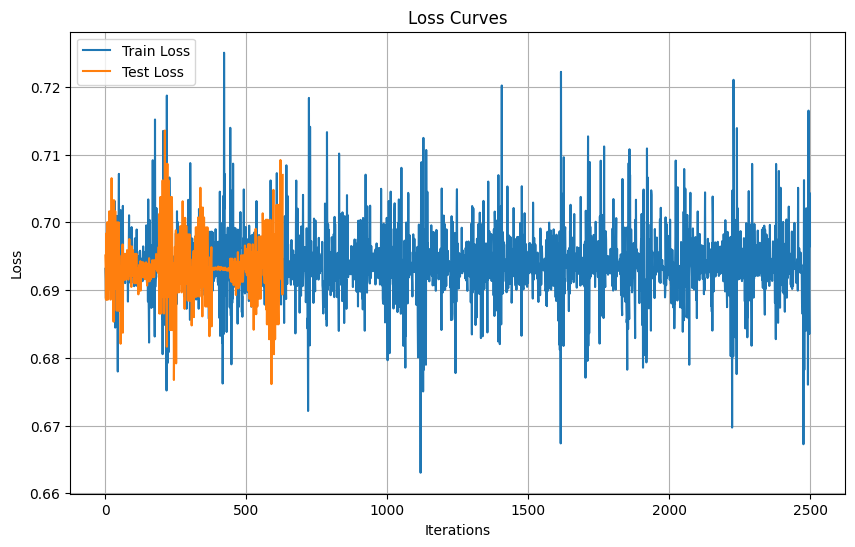

In [281]:
plot_loss_curves(losses_train, losses_test, file_name="mlp_loss_curves_large_2")

**Report what you observe on the training/test loss curves (related to a term we mentioned in the lecture)**

The toy moon dataset from Sklearn is a non-linearly separable dataset with two intertwined classes. The current MLP architecture with two hidden layers is sufficient to capture the underlying patterns in the data, as every continuous function can be approximated with two hidden layers. The training loss curve and the test loss curve exhibit the expected reduction in loss and approach a minimum. However, with larger amounts of hidden units and deeper architectures, the network struggles to learn any meaningful patterns from the input dataset. This might be due to the use of ReLU activations, which can cause the "dying ReLU" problem.

ReLU activations have no zero-centered output, which can result in "zig-zag" updates where all gradients become either negative or positive, and the update direction reflects this change in the network. Additionally, there is no gradient for x < 0 since the value is set to zero. If the gradient becomes 0, it is defined as the "dying ReLU" problem, where information cannot be propagated backwards through the network, causing some parts of the network to die and never activate again. Conversely, if the gradients become very large, ReLU acts like an identity function for positive values and is unbounded, leading to exploding gradients. This can cause large portions of units in the network to saturate and become inactive after a large gradient flow.

Initialization with Xavier can help mitigate the "dying ReLU" problem by ensuring that the weights are initialized with appropriate values that take into account the number of input and output units in each layer. The Xavier initialization method sets the weights of each layer to be within a range that is inversely proportional to the square root of the average of the number of input and output units in that layer. This helps to ensure that the variance of the outputs of each layer remains consistent, which in turn allows the gradients to flow more easily through the network during backpropagation.

### Task 2: Data Preparation and Visualization

In [282]:
# prepare data for training and testing
def load_data(train=True):
    """Load train- test split for MNIST"""
    mnist = datasets.MNIST('../data',
                train=train,
                download=True)
    return mnist

In [283]:
# 1.1 Load MNIST dataset
# load train split
data_train = load_data(train=True)
data_test = load_data(train=False)

print(len(data_train))
print(len(data_test))

60000
10000


In [284]:
def plot_examples(data):
    """ Plot some examples and put their corresponding label on top as title."""
    train_set_array = np.fliplr(data.data.numpy()) # data is l-r flipped
    train_set_array_targets = data.targets.numpy()
    
    # set title for image with subplot

    fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for i in range(10):
        axs[i].contourf(train_set_array[i], 5, cmap=plt.cm.Greys)
        axs[i].set_title(train_set_array_targets[i]) 
    
    # Set a single title for the entire figure
    fig.suptitle('MNIST Dataset', fontsize=20)

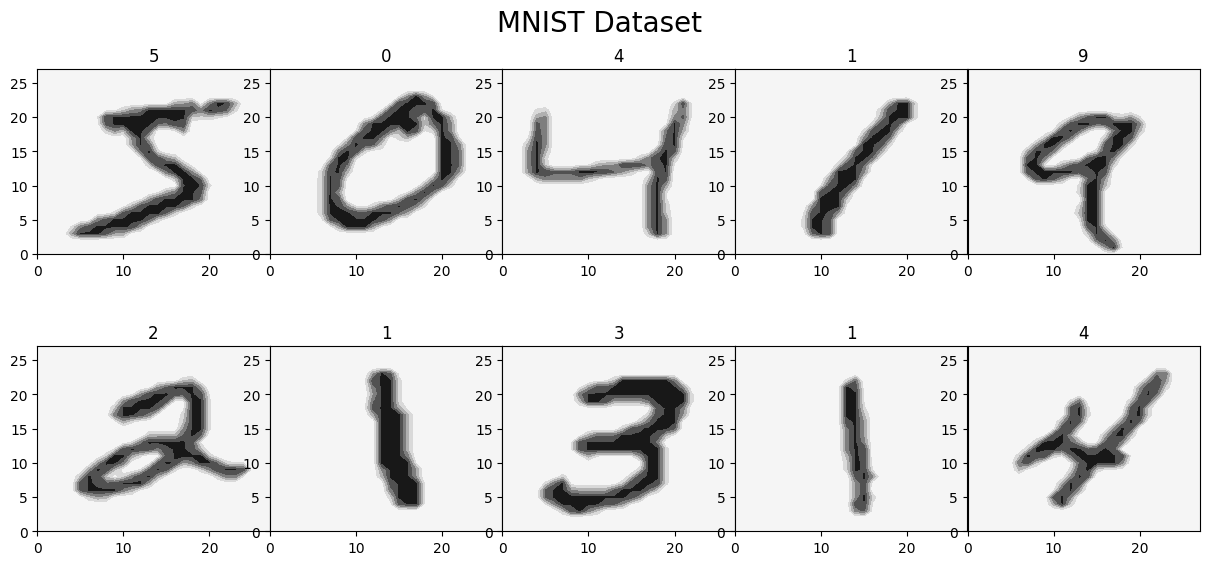

In [285]:
# 1.2 Plot some examples from the training set
plot_examples(data_train)

In [286]:
def plot_report(data: np.array):
    """Plot the report for the data."""
    v_sum = np.sum(data)
    v_min = np.min(data)
    v_max = np.max(data)
    v_mean = np.mean(data)
    v_shape = data.shape
    v_dtype = data.dtype

    print("Report for train set")
    print(f"Train Sum: {v_sum}")
    print(f"Train Min: {v_min}")
    print(f"Train Max: {v_max}")
    print(f"Train Mean: {v_mean}")
    print(f"Train Shape: {v_shape}")
    print(f"Train Datatype: {v_dtype}")

In [287]:
# 1.3 Give a report about min, max, mean, and std of the training set
train_set_array = data_train.data.numpy() # data is l-r flipped
plot_report(train_set_array)

Report for train set
Train Sum: 1567298545
Train Min: 0
Train Max: 255
Train Mean: 33.318421449829934
Train Shape: (60000, 28, 28)
Train Datatype: uint8


In [288]:
def convert_mnist_to_vectors(data):
    '''Converts the ``[28, 28]`` MNIST images to vectors of size ``[28*28]``.
       It outputs mnist_vectors as a array with the shape of [N, 784], where
       N is the number of images in data.
    '''

    mnist_vectors = []
    labels = []

    for image, label in tqdm(data):
        img_array = np.asarray(image)
        img_array = np.reshape(img_array, -1) # reshape array to vector
        mnist_vectors.append(img_array)
        labels.append(label)

    # return as numpy arrays
    return np.array(mnist_vectors), labels


def normalise_data(data: np.array) -> np.array:
    """ Normalise vectors to be in a range of [-1, 1]
        Improves convergence of the model since gradients are in a similar range.
    """
    data = data.copy()
    return 2*(data - np.min(data))/np.ptp(data) - 1

In [289]:
# 2. Convert all images into plain vectors and process them to be centered around 0
mnist_vectors, labels = convert_mnist_to_vectors(data_train)

# normalize data
mnist_vectors = normalise_data(np.array(mnist_vectors))

print(mnist_vectors[:1].shape)
print(mnist_vectors.shape)

100%|██████████| 60000/60000 [00:00<00:00, 88428.41it/s]


(1, 784)
(60000, 784)


In [290]:
plot_report(mnist_vectors)

Report for train set
Train Sum: -40993291.16078458
Train Min: -1.0
Train Max: -0.0039215686274509665
Train Mean: -0.8714560195745021
Train Shape: (60000, 784)
Train Datatype: float64


In [291]:
# Normalised [-1,1]
norm_mnist_mean = np.mean(mnist_vectors)
print(f"Train Mean: {norm_mnist_mean}")

Train Mean: -0.8714560195745021


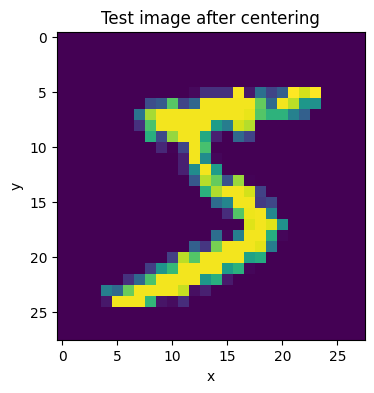

In [292]:
test_img = mnist_vectors[:1]
test_img = test_img.reshape((28, 28))
plt.imshow(test_img, interpolation='nearest')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Test image after centering")
plt.show()

In [293]:
def do_pca(data):
    '''Returns matrix [784x784] whose columns are the sorted eigenvectors.
       Eigenvectors (prinicipal components) are sorted according to their
       eigenvalues in decreasing order.
    '''

    mnist_vectors, _ = convert_mnist_to_vectors(data)
    # prepare_data(mnist_vectors)

    # compute covariance matrix of data with shape [784x784]
    cov = np.cov(mnist_vectors.T)

    # compute eigenvalues and vectors
    eigVals, eigVec = np.linalg.eig(cov)

    # sort eigenVectors by eigenValues
    # the earlier eigenVectors have more information about the data
    sorted_index = eigVals.argsort()[::-1]
    eigVals = eigVals[sorted_index]
    sorted_eigenVectors = eigVec[:, sorted_index]
    print(type(sorted_eigenVectors), sorted_eigenVectors.shape)
    return sorted_eigenVectors.astype(np.float32).T

In [294]:
# 3. Run PCA on the MNIST dataset
eigenVectors = do_pca(data_train)

100%|██████████| 60000/60000 [00:00<00:00, 84325.08it/s]


<class 'numpy.ndarray'> (784, 784)


/var/folders/4h/v0fwv1zs4596mmdvwj516k840000gn/T/ipykernel_1283/3987593753.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  return sorted_eigenVectors.astype(np.float32).T


In [295]:
def plot_pcs(sorted_eigenVectors, num=10):
    '''Plots the first ``num`` eigenVectors as images.'''
    fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for i in range(num):
        img = sorted_eigenVectors[i,].reshape((28, 28))
        axs[i].contourf(img, 5, cmap=plt.cm.Oranges)
        axs[i].set_title(f"Principal Component {i}")
    
    # Set a single title for the entire figure
    fig.suptitle('Selected MNIST Dataset Eigenvectors', fontsize=20)

    # save plot to results folder
    plt.savefig(f"{RESULTS_PATH}/pca_components.png", dpi=300)

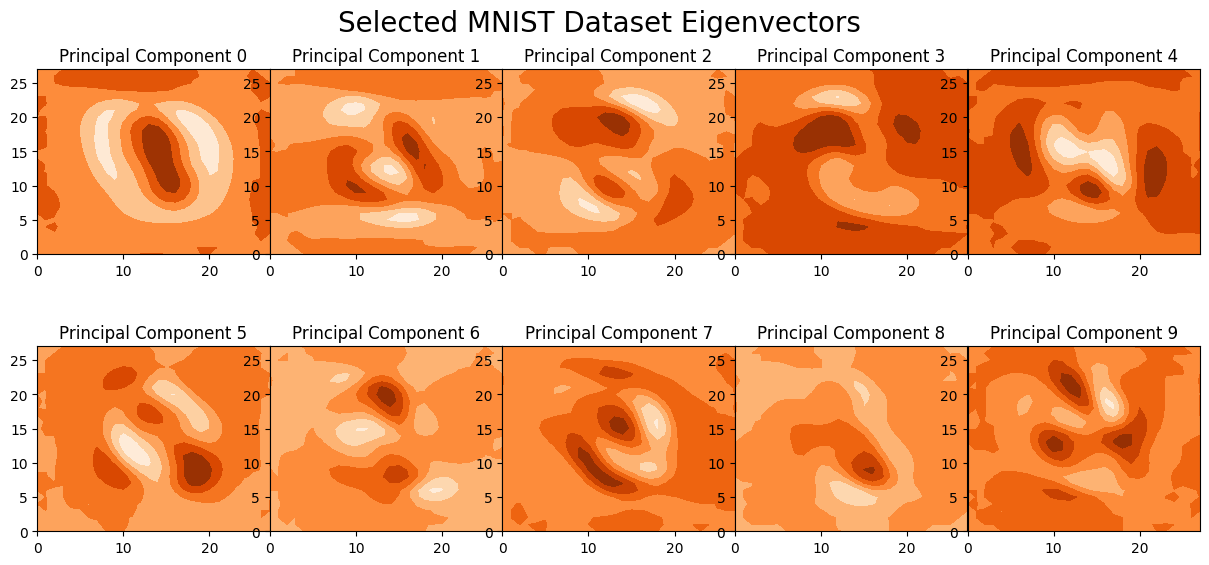

In [296]:
# 3.2 Plot the first 10 principal components
plot_pcs(eigenVectors)

**Explain what can be observed?**

The plot visualize the ten most important principal components, which allows to explain the greatest amount of variance in the original features. Thereby, PCA identifies directions (or principal components) along which the variation in the data is maximal. Hereby, it can be observed that the spread of the values is relatively large on the y-axis with relatively less spread (variance) on the x-axis. However, since the input data follows some wave-type structure (hand-written digits) after the projection the wave shapes also show up as distortion in the plots. Thereby, a linear correlation of the principal component values is not observable. The different values for the principal components do not show any clear linear relationship between the variance of the features in the dataset. We can derive that the classes are not linear seperable. The MNIST data further does not follow a multidimensional normal (Gaussian) distribution.

**What would you expect the principal components to look like, if the problem was easy?**

If the problem was easy a linear relationship, or strong linear correlation would be observable. However, the MNIST classes are not linearly seperable which makes the problem more challenging. Additionally, a large spread, or great variance is visible.

In [297]:
# create random colours
from random import randint

def generate_colors(amount: int) -> list:
    colors = []
    for i in range(amount):
        colors.append('#%06X' % randint(0, 0xFFFFFF))
    return colors

In [298]:
def project_vec_2Dspace(x, y):
    """ Use of the dot product to project vectors onto each other."""
    return np.dot(x, y)

In [299]:
def plot_projection(sorted_eigenVectors, data, subset=None, path=RESULTS_PATH):
    ''' Projects ``data`` onto the first two ``sorted_eigenVectors`` and makes
        a scatterplot of the resulting points
    '''
    if subset is None:
        N = len(list(data))
    else:
        N = subset

    # prepare data as vectors
    mnist_vectors, labels = convert_mnist_to_vectors(data)
    
    # projection of the first two vetors in 2D feature space
    pc1s = np.array([project_vec_2Dspace(x, y=sorted_eigenVectors[0]) for x in mnist_vectors[:N,]])
    pc2s = np.array([project_vec_2Dspace(x, y=sorted_eigenVectors[1]) for x in mnist_vectors[:N,]])

    # get random colours
    unique_labels = np.unique(labels[:N])
    cdict = generate_colors(len(unique_labels))

    # plot all datapoints 
    fig, ax = plt.subplots()
    for g in unique_labels:
        ix = np.where(labels[:N] == g)
        x = list(pc1s[ix])
        y = list(pc2s[ix])
        ax.scatter(x, y, c=cdict[g], marker='.', label=f'class {g}')
    
    ax.legend()
    ax.grid()
    plt.title(f'Two Component PCA with {N} Samples')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

    fig.savefig(f'./{path}/pca.png', dpi=fig.dpi)

(2, 784)


100%|██████████| 60000/60000 [00:00<00:00, 83270.87it/s]


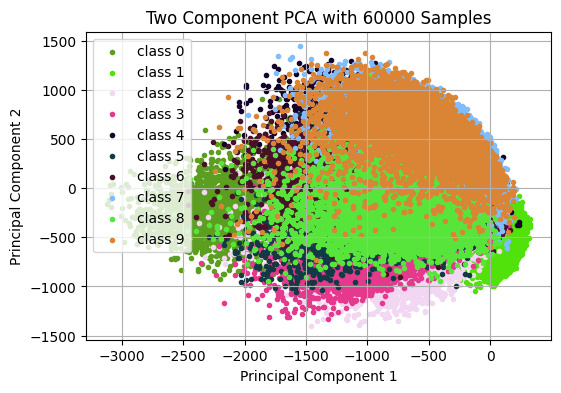

In [300]:
# 4. Project the MNIST vectors of the train set onto the two most important principal components
# find the two main important PCs, we can already separate the images somehow 
two_main_components = eigenVectors[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(sorted_eigenVectors=two_main_components, data=data_train)   

**Interpret the plot. What can it tell us about the MNIST dataset? Can you make a statement regarding the difficulty of MNIST digit classification problem?**

The diagram shows strong clusters and overlaps between the projected classes displaied, but little linear correlation within a class. Only very few classes can be separated, most are overlapping and mixed in the same PCA space. In this case, PCA may not well suited to capture non-linear relationships in a high-dimensional data set since it is itself a linear dimensionality reduction technique.

### Task 3: Defining, Training and Evaluating an MLP

In [301]:
# 1 build 5-layer MLP
class MultilayerPerceptron(nn.Module):
    """ The multilayer perceptron does a matrix multiplication of its 
        internal weights with the inputs and adds a bias in
        each layer. After that it activates the resulting vector.
        This can be done using the `Linear` layer. 
    """
    
    def __init__(self, size_hidden=100, size_out=10):
        """ Each hidden layer has 100 hidden units (output feature dimension).
            All hidden layers use ReLU activations.
        """
        super().__init__()
        # number of hidden nodes in each layer (100)
        # linear layer (784 -> hidden_1)
        self.fc1 = torch.nn.Linear(28*28, size_hidden) # Your Code here
        # linear layer (n_hidden -> n_hidden)
        self.fc2 = torch.nn.Linear(100, size_hidden)
        # linear layer (n_hidden -> n_hidden)
        self.fc3 = torch.nn.Linear(100, size_hidden)
        # linear layer (n_hidden -> n_hidden)
        self.fc4 = torch.nn.Linear(100, size_hidden)
        # linear layer (n_hidden -> size_out)
        self.out_layer = torch.nn.Linear(100, size_out)
        
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        # flatten the image, 
        # the -1 is a wildcard
        x = x.view(-1, 28*28)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        # flatten the output signal
        out = out.view(out.size(0), -1)
        out = self.out_layer(out)
        
        # no softmax as multi-class 
        # classification not probabilities

        return out

In [302]:
class MnistVectors(torch.utils.data.Dataset):
    ''' A Pytorch Dataset, which does the same 
        data preparation as was done in the PCA exercise.
    '''

    def __init__(self, split='train'):
        super().__init__()
        # torch dataset with casting operation
        mnist_train = datasets.MNIST('../data',
                               train=split=='train',
                               download=True)

        self.mnist_vectors, self.labels = convert_mnist_to_vectors(mnist_train)

            
    def __getitem__(self, idx):
        ''' Implements the ``[idx]`` method. Here we convert the numpy data to
            torch tensors.
        '''
        mvec = torch.tensor(self.mnist_vectors[idx]).float()
        label = torch.tensor(self.labels[idx]).long()

        return mvec, label
    
    def __len__(self):
        return len(self.labels)

In [303]:
# 3. Implement a function, which can report the accuracy of a batch of predictions in percent.

def batch_accuracy(prediction, label):
    """Uses labels to calculate the batch accuracy"""
    N = prediction.size(0)
    acc = prediction.eq(label.view_as(label)).sum().item()
    return (acc / N) * 100


def class_label(prediction):
    """ Transforms the output of the MultilayerPerceptron 
        into a scalar class label (index which matches predicted label: 0-9).
    """
    return prediction.argmax(dim=1)

def normalize_output(img):
    """ Normalizes the image to be in the range [0, 1]
        and converts it to a numpy array.
    """
    img = img - img.min()
    img = img / img.max()
    return img

In [304]:
# Visualize feature maps
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [305]:
# Visualize feature maps
act_fc1, act_fc2, act_fc3, act_fc4 = [], [], [], []
labels = []

In [306]:
def get_feature_maps(model, dataset=None, use_gpu=False):
    """ Get the feature maps of the model for a given dataset."""
    # define hook
    activation = {}

    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # register hooks
    model.fc1.register_forward_hook(get_activation('fc1'))
    model.fc2.register_forward_hook(get_activation('fc2'))
    model.fc3.register_forward_hook(get_activation('fc3'))
    model.fc4.register_forward_hook(get_activation('fc4'))

    if not dataset:
        dataset = datasets.MNIST(
        root='../data',
        train=False,
        transform=transforms.ToTensor()
    )

    count = 0
    with torch.no_grad():
        for data_sample, label in dataset:
            
            data_sample = np.reshape(data_sample, -1)
            data_sample.unsqueeze_(0)

            if use_gpu:
                data_sample = data_sample.cuda()
                label = label.cuda()
                
            pred = model(data_sample)

            act1 = activation['fc1'].squeeze()
            act2 = activation['fc2'].squeeze()
            act3 = activation['fc3'].squeeze()
            act4 = activation['fc4'].squeeze()

            # collect activated feature maps
            act_fc1.append(act1.detach().cpu().numpy())
            act_fc2.append(act2.detach().cpu().numpy())
            act_fc3.append(act3.detach().cpu().numpy())
            act_fc4.append(act4.detach().cpu().numpy())

            # collect all labels
            labels.append(label)
            count += 1

        print(f" Done after {count} steps!")

In [307]:
def validate(test, model, criterion, use_gpu=False):
        test_accuracies = []
        test_losses = []
        
        model.eval()
        
        with torch.no_grad():
            for idx, [test_examples, test_labels] in enumerate(tqdm(test, desc='Test')):
                if use_gpu:
                    test_examples = test_examples.cuda()
                    test_labels = test_labels.cuda()
                
                test_prediction = model(test_examples)
                
                # evaluation
                test_loss = criterion(test_prediction, test_labels).data.item()
                test_acc = batch_accuracy(class_label(test_prediction), test_labels)

                if (idx % 10) == 0:
                    print('Test Batch Accuracy: {}%, Test Loss: {}'.format(test_acc, test_loss))
                
                test_accuracies.append(test_acc) # per batch
                test_losses.append(test_loss)

        # Use the batch_accuracy function, also print the mean accuracy
        # over the whole test split of the data.

        print('Mean Validation Accuracy: {}%'.format(np.mean(test_accuracies)))
        print('Mean Validation Loss: {}%'.format(np.mean(test_losses)))

        plt.plot(test_accuracies)

In [308]:
def train(use_gpu=False): # if torch.cuda.is_available(), use gpu to speed up training
    
    # Here we instantiate our model. The weights of the model are automatically
    # initialized by pytorch
    model = MultilayerPerceptron()
    
    TrainData = MnistVectors()
    TestData = MnistVectors('test')

    # Dataloaders allow us to load the data in batches. This allows us a better
    # estimate of the parameter updates when doing backprop.
    # We need two Dataloaders so that we can train on the train data split
    # and evaluate on the test datasplit.
    
    Dl = DataLoader(TrainData, batch_size=32, shuffle=True)
    testDl = DataLoader(TestData, batch_size=32, shuffle=False)
    
    # Use the Adam optimizer with learning rate 1e-4 and otherwise default
    # values
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Use the Cross Entropy loss from pytorch. Make sure your MultilayerPerceptron does
    # not use any activation function on the output layer! (Do you know why?) 
    criterion = nn.CrossEntropyLoss()
    
    if use_gpu:
        model.cuda()
        criterion.cuda()
    
    for epoch in tqdm(range(5), desc='Epoch'):
        for step, [example, label] in enumerate(tqdm(Dl, desc='Batch')):
            if use_gpu:
                example = example.cuda()
                label = label.cuda()
            
            # The optimizer knows about all model parameters. These in turn
            # store their own gradients. When calling loss.backward() the newly
            # computed gradients are added on top of the existing ones. Thus
            # at before calculating new gradients we need to clear the old ones
            # using ther zero_grad() method.
            
            optimizer.zero_grad()
            
            prediction = model(example)
            loss = criterion(prediction, label)
            
            # Here pytorch applies backpropagation for us completely
            loss.backward()

            # The step method now adds the gradients onto the model parameters
            # as specified by the optimizer and the learning rate.
            optimizer.step()
            
            # To keep track of what is happening print some outputs from time to time.
            if (step % 375) == 0:
                acc = batch_accuracy(class_label(prediction), label)
                tqdm.write('Batch Accuracy: {}%, Loss: {}'.format(acc, loss))
        
        # checkpoints to reuse model weights
        torch.save(model.state_dict(), 'perceptron_{}.ckpt'.format(step))

    # Now validate on the whole test set
    validate(testDl, model, criterion, use_gpu)

    # If you need to load the checkpoint instanciate your model and the
    # load the state dict from a checkpoint:
    # model = MultilayerPerceptron()
    # model.load_state_dict(torch.load(perceptron_3750.ckpt))
    # Make sure to use the latest checkpoint by entering the right number.

    ######################################
    ######      Code for task 4     ######
    ######################################

    get_feature_maps(model, use_gpu=use_gpu)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]   

Batch Accuracy: 12.5%, Loss: 2.5277464389801025



Epoch:   0%|          | 0/5 [00:00<?, ?it/s]              

Batch Accuracy: 81.25%, Loss: 0.4840472638607025



Epoch:   0%|          | 0/5 [00:01<?, ?it/s]              

Batch Accuracy: 90.625%, Loss: 0.22633220255374908



Epoch:   0%|          | 0/5 [00:01<?, ?it/s]               

Batch Accuracy: 100.0%, Loss: 0.018305007368326187



Epoch:   0%|          | 0/5 [00:01<?, ?it/s]               

Batch Accuracy: 93.75%, Loss: 0.20569872856140137


Epoch:  20%|██        | 1/5 [00:02<00:10,  2.53s/it]

Batch Accuracy: 100.0%, Loss: 0.09550710022449493



Epoch:  20%|██        | 1/5 [00:03<00:10,  2.53s/it]      

Batch Accuracy: 100.0%, Loss: 0.015726856887340546



Epoch:  20%|██        | 1/5 [00:03<00:10,  2.53s/it]      

Batch Accuracy: 93.75%, Loss: 0.1709878295660019



Epoch:  20%|██        | 1/5 [00:04<00:10,  2.53s/it]       

Batch Accuracy: 96.875%, Loss: 0.08076770603656769



Epoch:  20%|██        | 1/5 [00:04<00:10,  2.53s/it]       

Batch Accuracy: 100.0%, Loss: 0.04389358311891556


Epoch:  40%|████      | 2/5 [00:05<00:08,  2.72s/it]

Batch Accuracy: 93.75%, Loss: 0.11248105764389038



Epoch:  40%|████      | 2/5 [00:05<00:08,  2.72s/it]      

Batch Accuracy: 100.0%, Loss: 0.024813491851091385



Epoch:  40%|████      | 2/5 [00:06<00:08,  2.72s/it]      

Batch Accuracy: 96.875%, Loss: 0.06339757144451141



Epoch:  40%|████      | 2/5 [00:07<00:08,  2.72s/it]       

Batch Accuracy: 90.625%, Loss: 0.24658213555812836



Epoch:  40%|████      | 2/5 [00:07<00:08,  2.72s/it]       

Batch Accuracy: 100.0%, Loss: 0.028342748060822487


Epoch:  60%|██████    | 3/5 [00:08<00:05,  2.86s/it]

Batch Accuracy: 100.0%, Loss: 0.012948368676006794



Epoch:  60%|██████    | 3/5 [00:08<00:05,  2.86s/it]      

Batch Accuracy: 100.0%, Loss: 0.04076691344380379



Epoch:  60%|██████    | 3/5 [00:09<00:05,  2.86s/it]      

Batch Accuracy: 100.0%, Loss: 0.005049258004873991



Epoch:  60%|██████    | 3/5 [00:10<00:05,  2.86s/it]       

Batch Accuracy: 96.875%, Loss: 0.09136185795068741



Epoch:  60%|██████    | 3/5 [00:10<00:05,  2.86s/it]       

Batch Accuracy: 96.875%, Loss: 0.04511060565710068


Epoch:  80%|████████  | 4/5 [00:11<00:02,  2.81s/it]

Batch Accuracy: 100.0%, Loss: 0.026252515614032745



Epoch:  80%|████████  | 4/5 [00:11<00:02,  2.81s/it]      

Batch Accuracy: 100.0%, Loss: 0.020044896751642227



Epoch:  80%|████████  | 4/5 [00:12<00:02,  2.81s/it]      

Batch Accuracy: 96.875%, Loss: 0.045521363615989685



Epoch:  80%|████████  | 4/5 [00:12<00:02,  2.81s/it]       

Batch Accuracy: 96.875%, Loss: 0.09870952367782593



Epoch:  80%|████████  | 4/5 [00:13<00:02,  2.81s/it]       

Batch Accuracy: 100.0%, Loss: 0.0042497869580984116


Test: 100%|██████████| 313/313 [00:00<00:00, 2771.65it/s]


Test Batch Accuracy: 100.0%, Test Loss: 0.030532503500580788
Test Batch Accuracy: 93.75%, Test Loss: 0.1995057761669159
Test Batch Accuracy: 96.875%, Test Loss: 0.0561971589922905
Test Batch Accuracy: 96.875%, Test Loss: 0.10312778502702713
Test Batch Accuracy: 93.75%, Test Loss: 0.28208282589912415
Test Batch Accuracy: 93.75%, Test Loss: 0.17268617451190948
Test Batch Accuracy: 96.875%, Test Loss: 0.07265093177556992
Test Batch Accuracy: 100.0%, Test Loss: 0.011488373391330242
Test Batch Accuracy: 96.875%, Test Loss: 0.07625538110733032
Test Batch Accuracy: 93.75%, Test Loss: 0.06542270630598068
Test Batch Accuracy: 90.625%, Test Loss: 0.21719485521316528
Test Batch Accuracy: 96.875%, Test Loss: 0.2740793228149414
Test Batch Accuracy: 93.75%, Test Loss: 0.15289725363254547
Test Batch Accuracy: 93.75%, Test Loss: 0.2133556753396988
Test Batch Accuracy: 93.75%, Test Loss: 0.3990713059902191
Test Batch Accuracy: 90.625%, Test Loss: 0.19733324646949768
Test Batch Accuracy: 96.875%, Test L

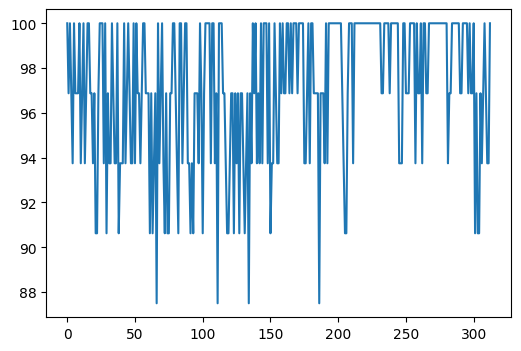

In [309]:
train(use_gpu=True if torch.cuda.is_available() else False)

#### Task 4: Visualizing MLP Features

In [310]:
# 1. MNIST images of the test split, or if you have limited computational resource for a subset of at least 1000 image
print(np.asarray(act_fc1).shape)

(10000, 100)


In [311]:
def norm_data(data):
    """ Normalizes the data to be in the range [0, 1]."""
    data = data - np.min(data)
    data = data / np.max(data)
    return data

In [312]:
# 2. find PCA of vectors and project feature maps onto the first two principal components
def convert_act_to_vectors(data):
    '''Converts the activated feature maps to vectors of size ``[n*m]``.
       It outputs mnist_vectors as a array with the shape of [N, n*m], where
       N is the number of maps in data.
    '''

    act_vectors = []

    for act in tqdm(data):
        act_array = np.asarray(act)
        act_array = np.reshape(act_array, -1) # reshape array to vector
        act_vectors.append(act_array)
    
    # return as numpy arrays
    return norm_data(np.array(act_vectors))

In [313]:
def do_pca_actm(data):
    '''Returns matrix [nxm] whose columns are the sorted eigenvectors.
       Eigenvectors (prinicipal components) are sorted according to their
       eigenvalues in decreasing order.
       >>> PCA compresses the input data into its representation.
    '''

    actm_vectors = convert_act_to_vectors(data)
    # prepare_data(actm_vectors)

    # compute covariance matrix of data
    cov = np.cov(actm_vectors.T)

    # compute eigenvalues and vectors
    eigVals, eigVec = np.linalg.eig(cov)

    # sort eigenVectors by eigenValues descending
    sorted_index = eigVals.argsort()[::-1]
    eigVals = eigVals[sorted_index]
    sorted_eigenVectors = eigVec[:, sorted_index]
    print(type(sorted_eigenVectors), sorted_eigenVectors.shape)
    
    return sorted_eigenVectors.astype(np.float64).T

In [314]:
pca_act_fc1 = do_pca_actm(act_fc1)
pca_act_fc2 = do_pca_actm(act_fc2)
pca_act_fc3 = do_pca_actm(act_fc3)
pca_act_fc4 = do_pca_actm(act_fc4)

print(pca_act_fc1.shape)
print(pca_act_fc2.shape)
print(pca_act_fc3.shape)
print(pca_act_fc4.shape)

100%|██████████| 10000/10000 [00:00<00:00, 1355011.95it/s]


<class 'numpy.ndarray'> (100, 100)


100%|██████████| 10000/10000 [00:00<00:00, 754887.15it/s]


<class 'numpy.ndarray'> (100, 100)


100%|██████████| 10000/10000 [00:00<00:00, 394042.26it/s]


<class 'numpy.ndarray'> (100, 100)


100%|██████████| 10000/10000 [00:00<00:00, 541214.48it/s]


<class 'numpy.ndarray'> (100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)


(2, 100)


10000it [00:00, 465852.61it/s]


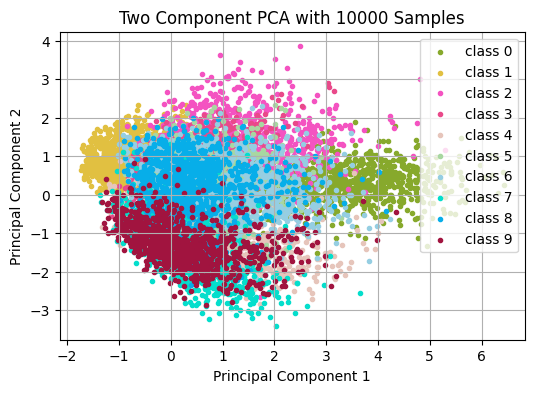

In [315]:
# 3. Make a scatter plot of the projected feature maps onto the first two principal components
# find the two main important PCs
two_main_components = pca_act_fc1[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(two_main_components, zip(act_fc1, labels), subset=len(labels))

(2, 100)


10000it [00:00, 1148400.73it/s]


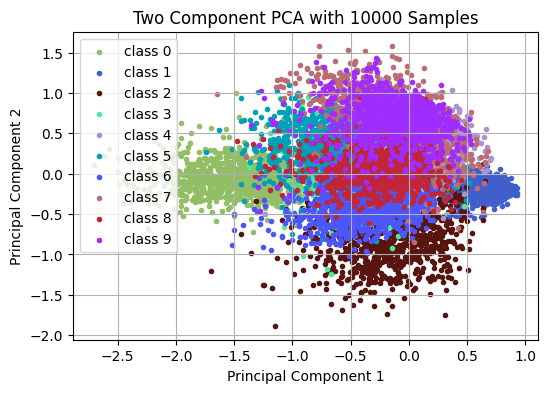

In [316]:
# find the two main important PCs
two_main_components = pca_act_fc2[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(two_main_components, zip(act_fc2, labels), subset=len(labels))

(2, 100)


10000it [00:00, 1214895.15it/s]


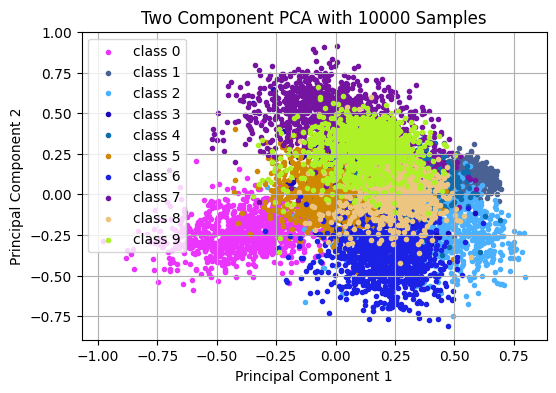

In [317]:
# find the two main important PCs
two_main_components = pca_act_fc3[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(two_main_components, zip(act_fc3, labels), subset=len(labels))

(2, 100)


10000it [00:00, 1297541.84it/s]


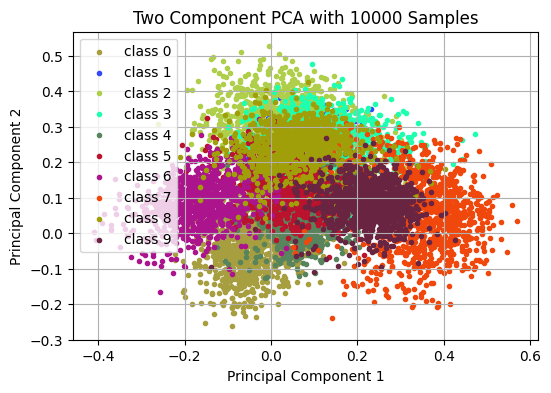

In [318]:
# find the two main important PCs
two_main_components = pca_act_fc4[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(two_main_components, zip(act_fc4, labels), subset=len(labels))

**Compare the plots to the scatter plot from task 2. What has changed, what is similar?**

The PCA plots show a progressive scattering of salient features along the x- and y-axis through the model layers. The later layers show distinct projections per class into various clusters. This is because the later layers of the model learn more complex and abstract features of the data, which can better separate the different classes or categories.

**Do you believe that the MLP is a suitable method for MNIST digit classification? Provide an explanation.**

MLPs are relatively simple and suitable for structured data, making them a good baseline model for MNIST digit classification. However, CNNs are better suited for processing large image datasets as they can capture spatial relationships between pixels and develop an internal representation of the training dataset. CNNs also use weight sharing, making them more parameter-efficient than MLPs. Therefore, while an MLP can be used as a starting point, a CNN is likely to achieve better performance on the MNIST dataset.
